In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data

## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

df  = pd.read_csv('/data/Data_Entry_2017.csv')
df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1444,00007501_003.png,Atelectasis|Infiltration|Pneumothorax,3,7501,053Y,F,AP,2500,2048,0.168,0.168
2471,00012428_003.png,No Finding,3,12428,062Y,F,AP,2500,2048,0.168,0.168
1426,00007406_003.png,No Finding,3,7406,066Y,M,AP,2500,2048,0.168,0.168


### CLEAN

In [3]:
# I will drop unecessary columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

In [4]:
df.describe()

,Follow-up #,Patient ID,Patient Age
count,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463
std,15.406320,8403.876972,16.839923
min,0.000000,1.000000,1.000000
25%,0.000000,7310.750000,35.000000
50%,3.000000,13993.000000,49.000000
75%,10.000000,20673.000000,59.000000
max,183.000000,30805.000000,414.000000


In [5]:
# There are some patients with age above 100. I will remove then.
df = df[df['Patient Age']<100]
print('Number of patients with age < 100: ',len(df))

Number of patients with age < 100:  112104


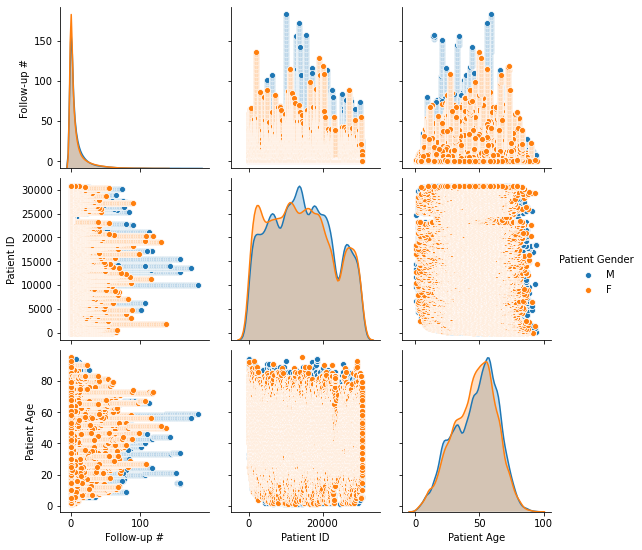

In [6]:
sns.pairplot(df,hue='Patient Gender')

### What is the gender and age distribution?

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


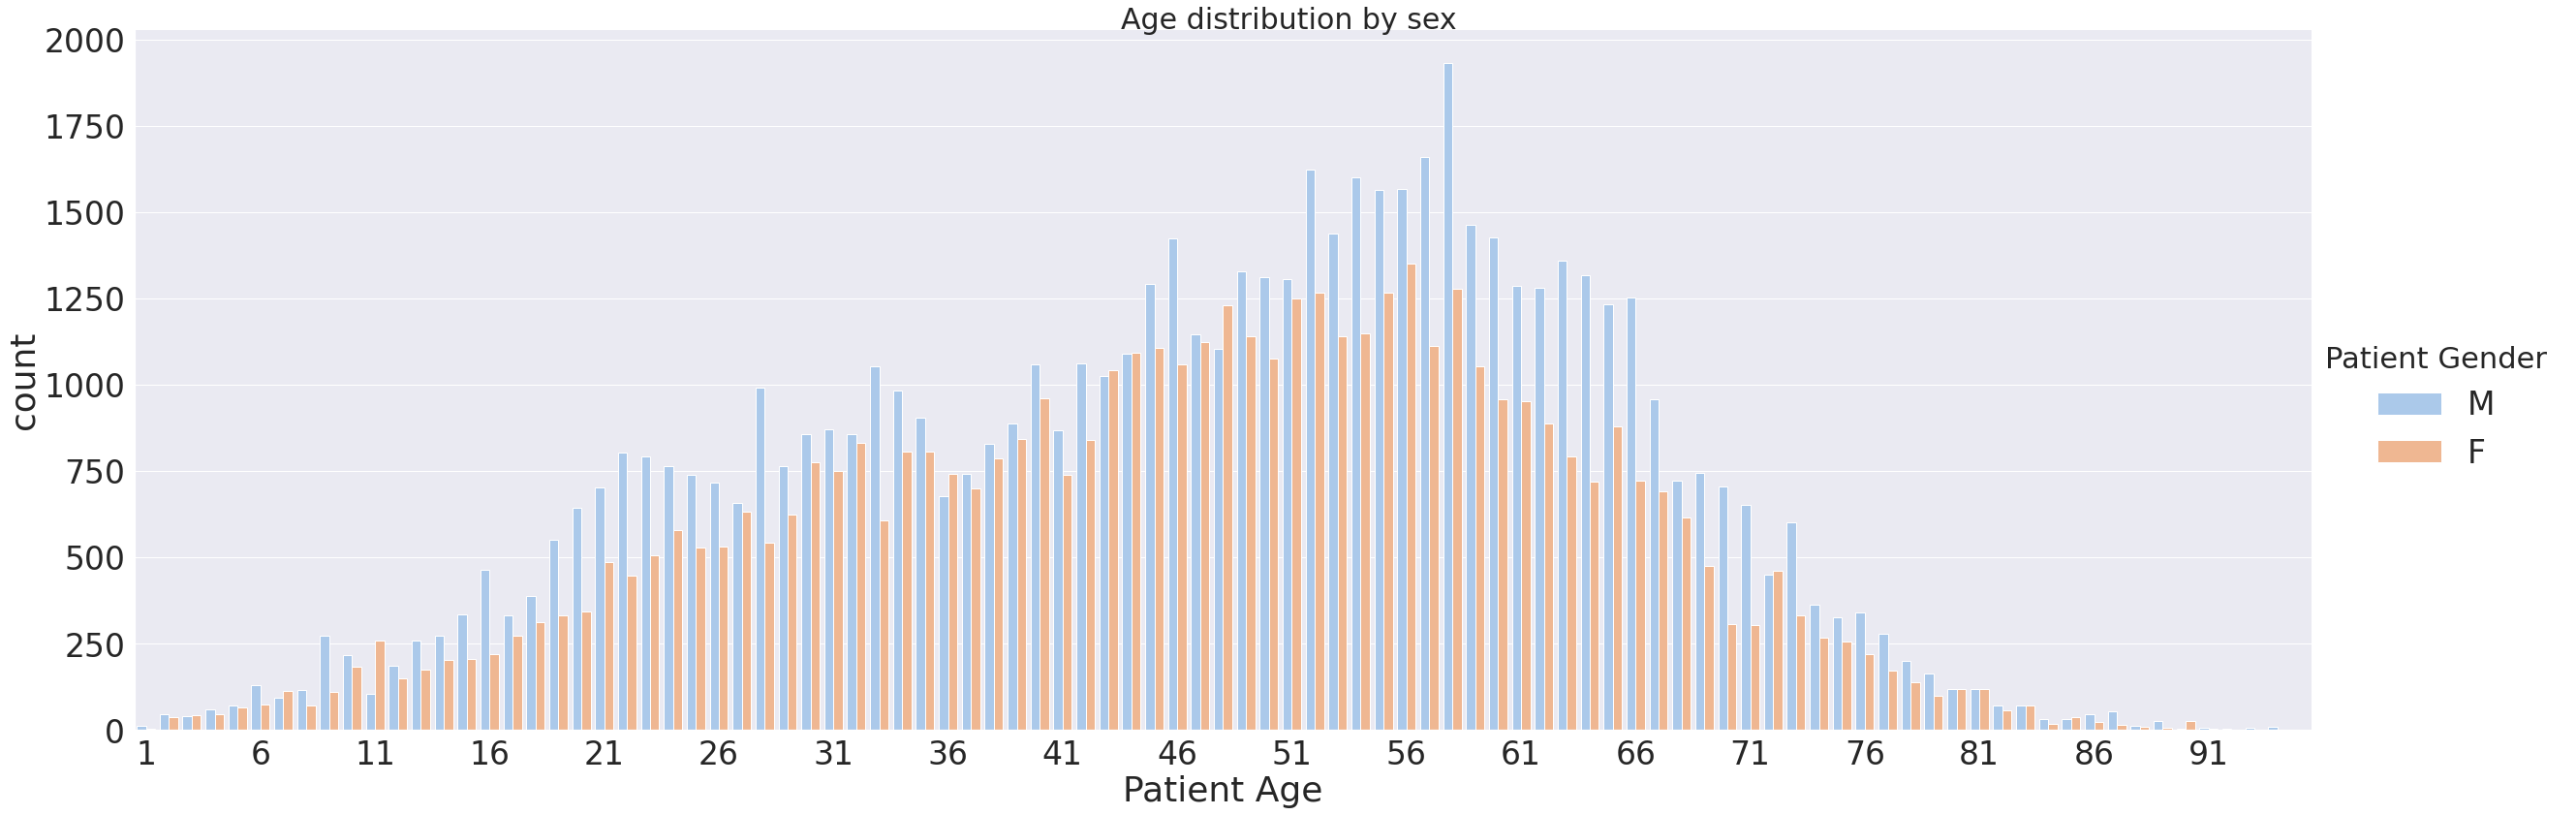

In [7]:
sns.set(font_scale = 3)
k = sns.factorplot(x="Patient Age", hue="Patient Gender", kind="count",
            palette="pastel",
            data=df,height=12.27, aspect=11.7/4.27);
k.set_xticklabels(step=5)
k.fig.suptitle('Age distribution by sex',fontsize=30);

In [8]:
df['Patient Male'] = df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
df['Patient Female'] = df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')

In [9]:
# add a pneumonia column (True/False). 
#Is the word "Pneumonia" contained in the "Finding Labels" column. 
df['Pneumonia'] = df['Finding Labels'].map(lambda x: 'Pneumonia' in x)

In [10]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Patient Male,Patient Female,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,1.0,1.0,False
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,1.0,1.0,False
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,1.0,1.0,False
3,00000002_000.png,No Finding,0,2,81,M,1.0,1.0,False
4,00000003_000.png,Hernia,0,3,81,F,0.0,0.0,False


### What is the gender distribution for Pneumonia patients?

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


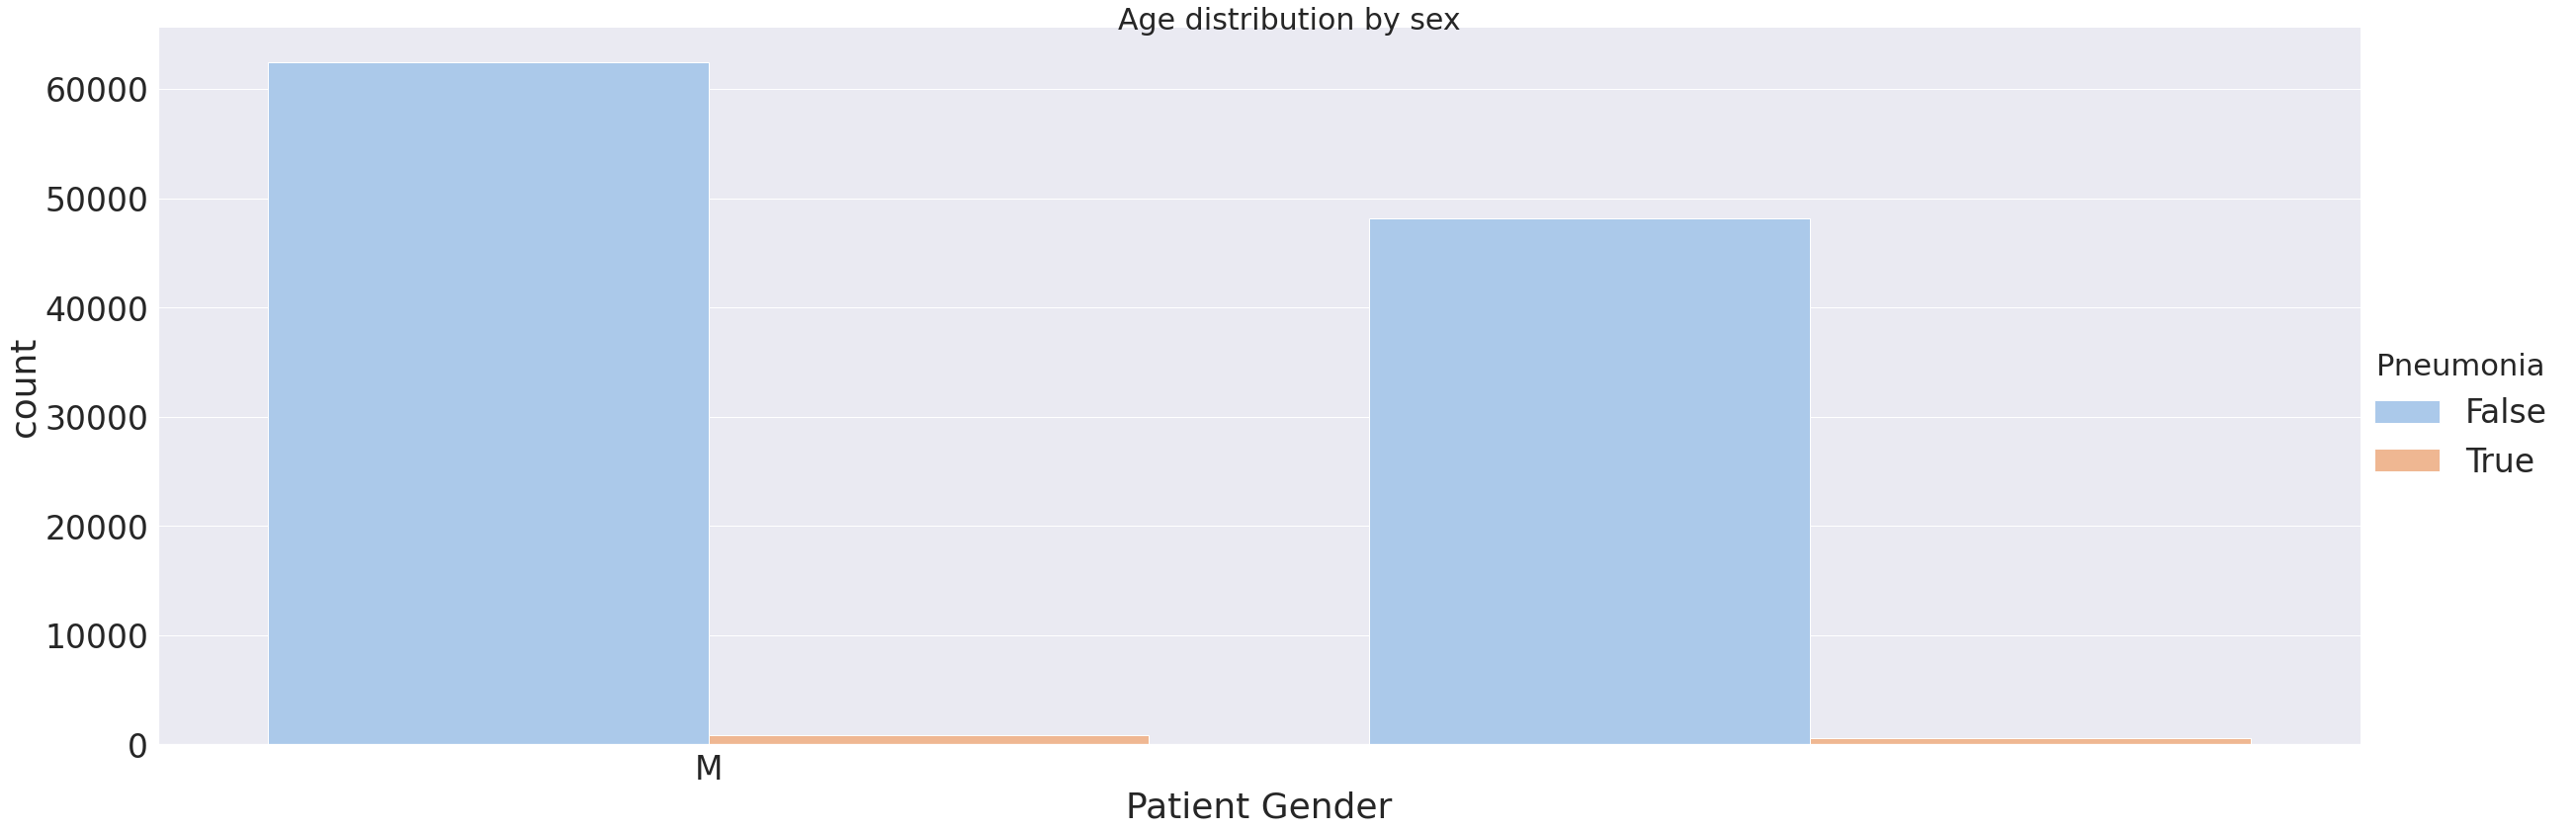

In [11]:
sns.set(font_scale = 3)
k = sns.factorplot(x="Patient Gender", hue="Pneumonia", kind="count",
            palette="pastel",
            data=df,height=12.27, aspect=11.7/4.27);
k.set_xticklabels(step=5)
k.fig.suptitle('Age distribution by sex',fontsize=30);

### What is the frequency of the diseases?

In [12]:
# I will count how many labels are present for each patient 
df['Labels_Count'] = df['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Patient Male,Patient Female,Pneumonia,Labels_Count
0,00000001_000.png,Cardiomegaly,0,1,58,M,1.0,1.0,False,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,1.0,1.0,False,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,1.0,1.0,False,2
3,00000002_000.png,No Finding,0,2,81,M,1.0,1.0,False,0
4,00000003_000.png,Hernia,0,3,81,F,0.0,0.0,False,1


In [13]:
# Defining all labels from diseases
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

> As some of the labels don't have only one disease, we cannot use dummy variables. Instead, I'm going to do it separately using a loop.

In [14]:
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: 
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [15]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Patient Male,Patient Female,Pneumonia,Labels_Count,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,1.0,1.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,1.0,1.0,0.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,1.0,1.0,0.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,1.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,0.0,0.0,0.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Calculating the percentage of each disease
label_counts = 100*np.mean(df[all_labels].values,0)

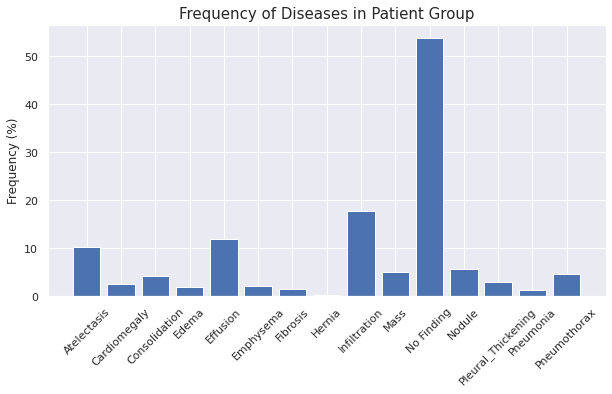

In [17]:
sns.set(font_scale = 1)
fig, ax1 = plt.subplots(1,1,figsize = (10, 5))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 45)
ax1.set_title('Frequency of Diseases in Patient Group',fontsize=15)
_ = ax1.set_ylabel('Frequency (%)',fontsize=12)

In [18]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Patient Male,Patient Female,Pneumonia,Labels_Count,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,1.0,1.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,1.0,1.0,0.0,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,1.0,1.0,0.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,1.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,0.0,0.0,0.0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### How many images are follow-ups?

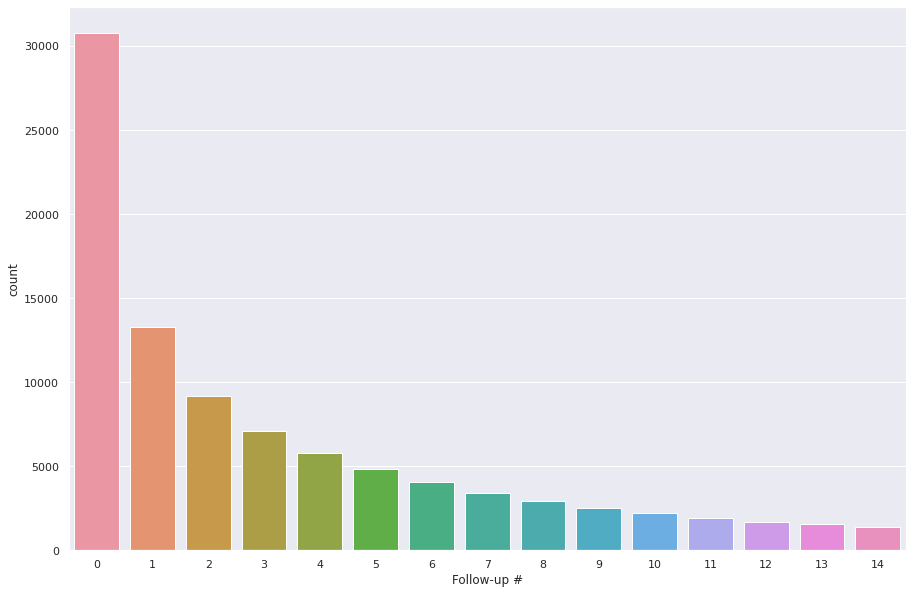

In [19]:
plt.figure(figsize=(15, 10))
data = df[df['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=data)

### What is the frequency of diseases when occuring alone and on multiple diagnostics?

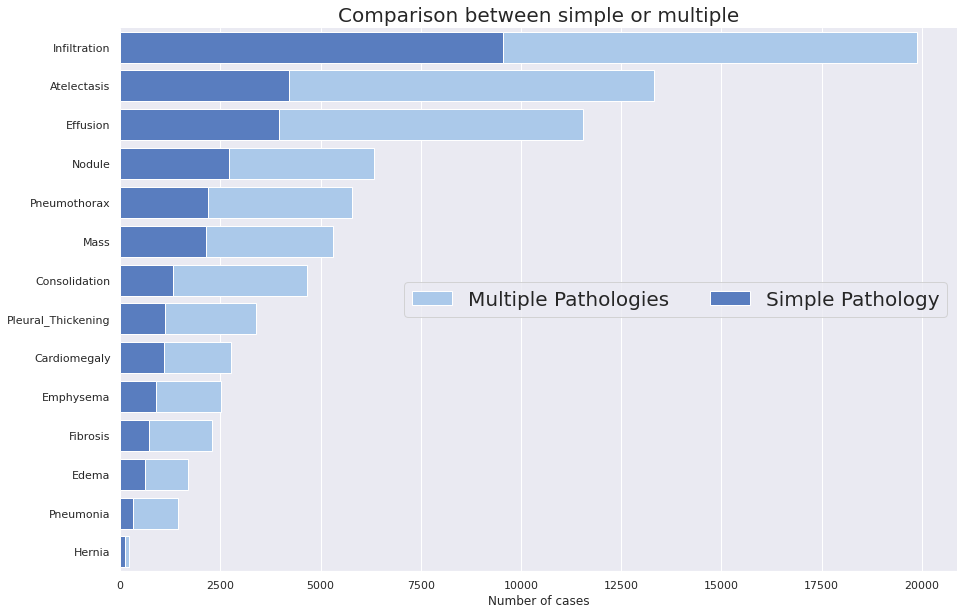

In [20]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

data1 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]

data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values


f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of cases")
ax.set_title("Comparison between simple or multiple",fontsize=20)      
sns.despine(left=True)


### What is the distribution of patients' age based on specific diseases?

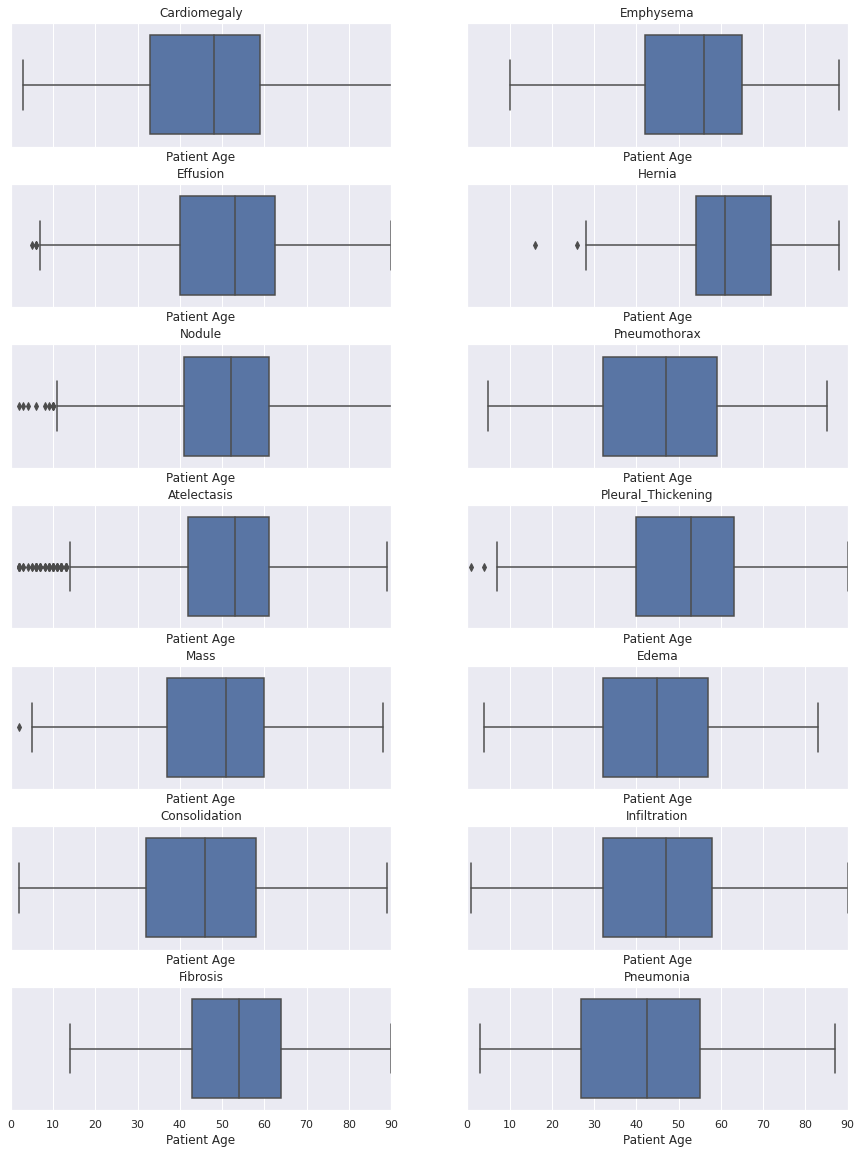

In [21]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.boxplot(x='Patient Age', hue="Patient Gender",data=df[df['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

### DICOM ANALYSIS

In [22]:
import glob
mydicoms = glob.glob("*.dcm")

No Finding


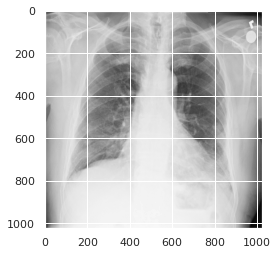

In [25]:
import pydicom

dcm1 = pydicom.dcmread(mydicoms[2])
plt.imshow(dcm1.pixel_array,cmap='gray')
print(dcm1.StudyDescription)

In [26]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

Looking at the attributes listed above, I can see that I'm looking to extract the following attributes: 
* Modality
* Study Description
* Patient ID
* Patient's Sex
* Patient's Age
* Rows
* Columns

In [27]:
dcm1.Modality

'DX'

In [28]:
dcm1.StudyDescription

'No Finding'

In [29]:
dcm1.PatientSex

'M'

In [30]:
dcm1.PatientAge

'81'

In [31]:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [32]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [33]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,1,58,M,DX,Cardiomegaly,1024,1024
1,2,81,M,CT,No Finding,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,2,81,M,DX,No Finding,1024,1024
4,2,81,M,DX,No Finding,1024,1024
5,61,77,M,DX,Effusion,1024,1024


(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 4.]),
 array([58. , 60.3, 62.6, 64.9, 67.2, 69.5, 71.8, 74.1, 76.4, 78.7, 81. ]),
 <a list of 10 Patch objects>)

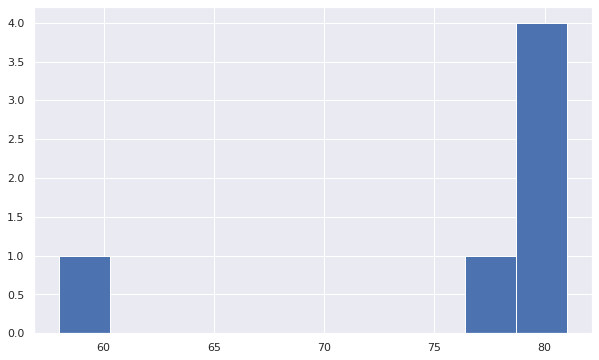

In [34]:
plt.figure(figsize=(10,6))
plt.hist(mydata['PatientAge'])

### What is the distribution of pixels of No Finding X-ray? 

Text(0, 0.5, '# Pixels in Image')

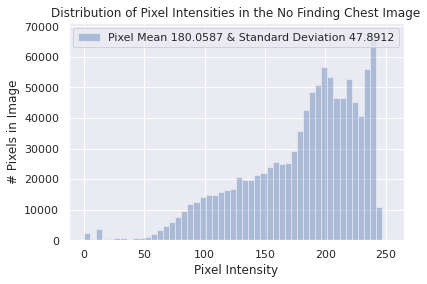

In [35]:
sns.distplot(dcm1.pixel_array.ravel(), 
             label=f'Pixel Mean {np.mean(dcm1.pixel_array.ravel()):.4f} & Standard Deviation {np.std(dcm1.pixel_array.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the No Finding Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

mean intensity: 180.0586576461792
std intensity: 47.89115072730743


Text(0, 0.5, '# Pixels in Image')

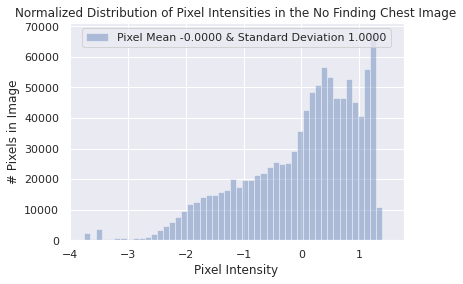

In [36]:
mean_intensity = np.mean(dcm1.pixel_array)
print("mean intensity:", mean_intensity)
std_intensity = np.std(dcm1.pixel_array)
print("std intensity:",std_intensity)
new_img = dcm1.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
sns.distplot(new_img.ravel(), 
             label=f'Pixel Mean {np.mean(new_img.ravel()):.4f} & Standard Deviation {np.std(new_img.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Normalized Distribution of Pixel Intensities in the No Finding Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')


### What is the distribution of pixels of Cardiomegaly image? 

In [37]:
dcm2 = pydicom.dcmread(mydicoms[0])
dcm2.StudyDescription

'Cardiomegaly'

Cardiomegaly


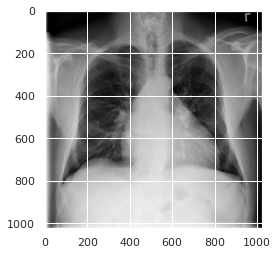

In [38]:
plt.imshow(dcm2.pixel_array,cmap='gray')
print(dcm2.StudyDescription)

Text(0, 0.5, '# Pixels in Image')

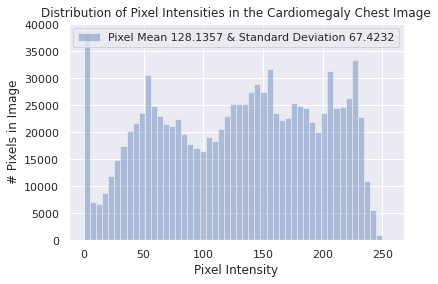

In [39]:
sns.distplot(dcm2.pixel_array.ravel(), 
             label=f'Pixel Mean {np.mean(dcm2.pixel_array.ravel()):.4f} & Standard Deviation {np.std(dcm2.pixel_array.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Cardiomegaly Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

mean intensity: 128.13570880889893
std intensity: 67.42323200014457


Text(0, 0.5, '# Pixels in Image')

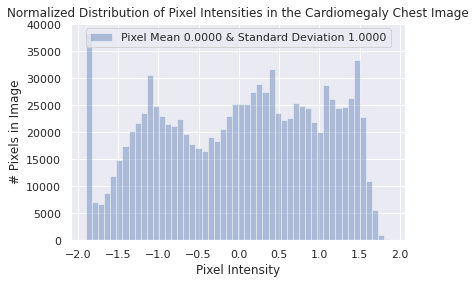

In [40]:
mean_intensity = np.mean(dcm2.pixel_array)
print("mean intensity:", mean_intensity)
std_intensity = np.std(dcm2.pixel_array)
print("std intensity:",std_intensity)
new_img = dcm2.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
sns.distplot(new_img.ravel(), 
             label=f'Pixel Mean {np.mean(new_img.ravel()):.4f} & Standard Deviation {np.std(new_img.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Normalized Distribution of Pixel Intensities in the Cardiomegaly Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

### What is the distribution of pixels of Effusion X-ray? 

In [41]:
dcm3 = pydicom.dcmread(mydicoms[5])
dcm3.StudyDescription

'Effusion'

Effusion


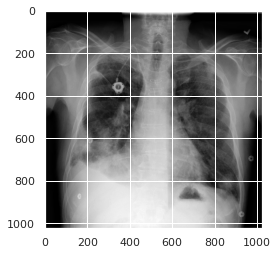

In [42]:
plt.imshow(dcm3.pixel_array,cmap='gray')
print(dcm3.StudyDescription)

Text(0, 0.5, '# Pixels in Image')

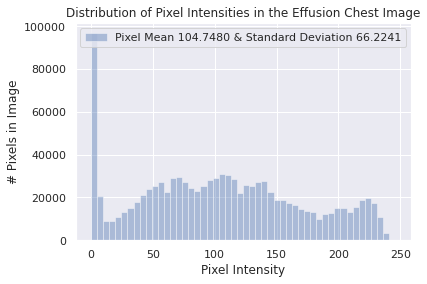

In [43]:
sns.distplot(dcm3.pixel_array.ravel(), 
             label=f'Pixel Mean {np.mean(dcm3.pixel_array.ravel()):.4f} & Standard Deviation {np.std(dcm3.pixel_array.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Effusion Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

mean intensity: 104.74800395965576
std intensity: 66.22413614301003


Text(0, 0.5, '# Pixels in Image')

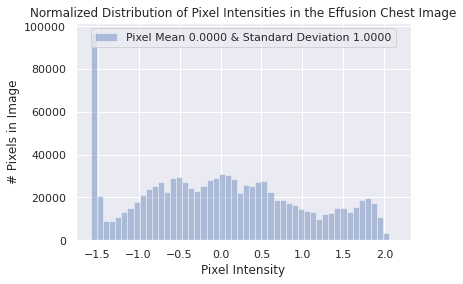

In [44]:
mean_intensity = np.mean(dcm3.pixel_array)
print("mean intensity:", mean_intensity)
std_intensity = np.std(dcm3.pixel_array)
print("std intensity:",std_intensity)
new_img = dcm3.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
sns.distplot(new_img.ravel(), 
             label=f'Pixel Mean {np.mean(new_img.ravel()):.4f} & Standard Deviation {np.std(new_img.ravel()):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Normalized Distribution of Pixel Intensities in the Effusion Chest Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In radiology studies (which include X-ray, CT scan, MRI, and ultrasound), pictures are shades of black, white, and gray. Dense or solid structures such as bone, heart, and major blood vessels appear white. By contrast, air-filled structures such as the lungs will appear black. Overlapping structures or anything in between will appear in shades of gray.

Radiology scans are sometimes difficult to read because structures do overlap, and, even if you spot an abnormality, it can hard to discern what it is. While some abnormalities may be defined structures such as a mass, nodule, or tumor, at other times their appearance may not be so well defined.

We can see from the pixel distribution that the intensity of the pixel determines if we have a skewed distribution or not, which indicates the type of pathology.